Min: [0.663545] Max: [1.4] 90% Quantile: [1.39594]


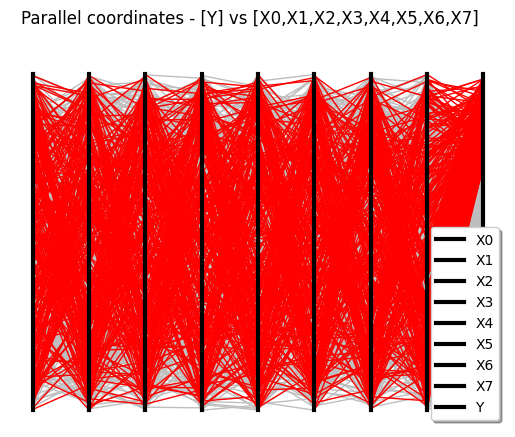

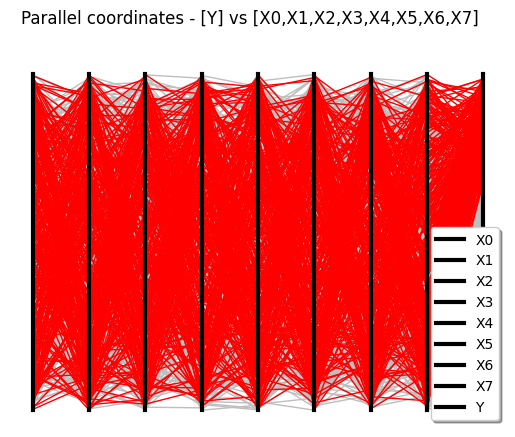

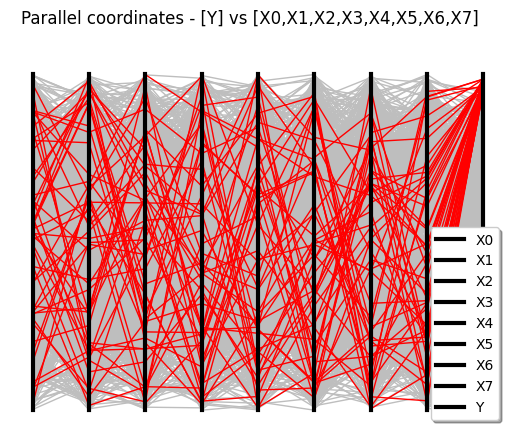

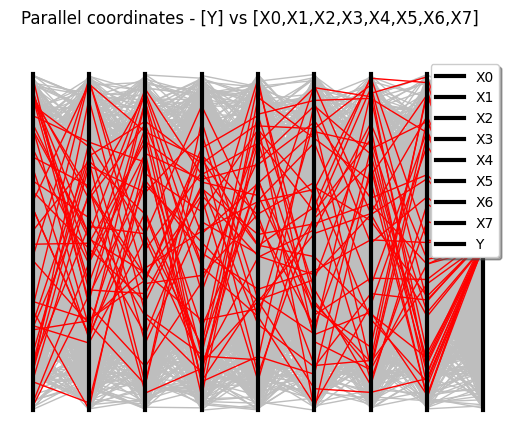

In [2]:
"""
Visualize sensitivity
=====================
"""

import openturns as ot
import importlib.util
import sys
import os
import openturns.viewer as viewer
from matplotlib import pylab as plt
import pandas as pd

ot.Log.Show(ot.Log.NONE)

# Function to load a module from a file
def load_function_and_problem(module_name, file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None:
        raise ImportError(f"Could not load the module from {file_path}.")
    
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module.model, module.problem

# Function to create OpenTURNS distributions from the problem definition
def create_distributions(problem):
    distributions = ot.DistributionCollection()
    for dist_info in problem['distributions']:
        dist_type = dist_info['type']
        params = dist_info['params']
        if dist_type == 'Uniform':
            distributions.add(ot.Uniform(*params))
        elif dist_type == 'Normal':
            distributions.add(ot.Normal(*params))
        elif dist_type == 'LogNormalMuSigma':
            distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
        elif dist_type == 'LogNormal':
            distributions.add(ot.LogNormal(*params))
        elif dist_type == 'Beta':
            distributions.add(ot.Beta(*params))
        elif dist_type == 'Gumbel':
            distributions.add(ot.Gumbel(*params))
        elif dist_type == 'Triangular':
            distributions.add(ot.Triangular(*params))
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")
    return ot.ComposedDistribution(distributions)

# Function to save plotted data to CSV
def save_plotted_data_to_csv(X, Y, file_path):
    """
    Save input and output samples to a CSV file.

    Parameters:
    - X: Input samples.
    - Y: Output samples.
    - file_path: The file path to save the CSV file.

    CSV File Columns:
    - Input1, Input2, ..., InputN: The input sample values.
    - Output: The output sample values.
    """
    X_file = "results/X.csv"
    Y_file = "results/Y.csv"

    X.exportToCSVFile(X_file, ",")
    Y.exportToCSVFile(Y_file, ",")

    X_df = pd.read_csv(X_file)
    Y_df = pd.read_csv(Y_file)

    data = pd.concat([Y_df,X_df], axis=1)
    data.to_csv(file_path, index=False)

    os.remove(X_file)
    os.remove(Y_file)

def main(module_name, file_path, output_csv_path):
    function_of_interest, problem = load_function_and_problem(module_name, file_path)

    # Define the OpenTURNS model
    ot_model = ot.PythonFunction(problem['num_vars'], 1, function_of_interest)
    
    # Create the input distribution
    distribution = create_distributions(problem)

    # Create a random vector that follows the distribution of the input variables
    input_vector = ot.RandomVector(distribution)

    # The random variable of interest Y is then
    output = ot.CompositeRandomVector(ot_model, input_vector)

    # Generate an input sample of size N
    N = 1000
    X = input_vector.getSample(N)

    # Evaluate the associated output sample
    Y = output.getSample(N)
    Y.setDescription(["Y"])

    # Display the minimum, maximum, and value of the 90% quantile of Y
    print("Min:", Y.getMin(), "Max:", Y.getMax(), "90% Quantile:", Y.computeQuantilePerComponent(0.9))

    # Save input and output samples to CSV
    save_plotted_data_to_csv(X, Y, output_csv_path)

    # Value based scale to describe the Y range
    minValue = 0.85 * Y.getMax()[0]
    maxValue = Y.getMax()[0]
    quantileScale = False
    graph = ot.VisualTest.DrawParallelCoordinates(X, Y, minValue, maxValue, "red", quantileScale)
    graph.setLegendPosition("lower right")
    view = viewer.View(graph)

    # Another range
    minValue = 0.80 * Y.getMax()[0]
    maxValue = Y.getMax()[0]
    quantileScale = False
    graph = ot.VisualTest.DrawParallelCoordinates(X, Y, minValue, maxValue, "red", quantileScale)
    graph.setLegendPosition("lower right")
    view = viewer.View(graph)

    # Quantile based scale to describe the Y range
    minValue = 0.95
    maxValue = 1.0
    quantileScale = True
    graph = ot.VisualTest.DrawParallelCoordinates(X, Y, minValue, maxValue, "red", quantileScale)
    graph.setLegendPosition("lower right")
    view = viewer.View(graph)

    # When the parallel plot brings nothing
    minValue = 0.48
    maxValue = 0.52
    quantileScale = True
    graph = ot.VisualTest.DrawParallelCoordinates(X, Y, minValue, maxValue, "red", quantileScale)
    graph.setLegendPosition("upper right")
    view = viewer.View(graph)

    # Display figures
    plt.show()

# Run the main function
if __name__ == "__main__":
    module_name = "FloodModel"
    file_path = "examples/FloodModel.py"
    output_csv_path = "results/flood_model_plot_data.csv"
    os.makedirs("results", exist_ok=True)
    main(module_name, file_path, output_csv_path)


In [ ]:
Sure, let's generalize the description to apply to any model, not just the flood model.

### Description of the Data and Cobweb Plot Interpretation

#### Data Description
The data consists of input and output samples from a model simulation. The input variables represent different parameters that influence the model, and the output variable represents the resulting value from the model. The data is organized in a CSV file with the following structure:

- **Input Variables (X0, X1, ..., Xn)**: These columns represent the various input parameters to the model.
- **Output Variable (Y)**: This column represents the output value of the model corresponding to the input parameters.

#### Cobweb Plot Representation
A cobweb plot, also known as a parallel coordinates plot, is a visualization tool used to understand the relationships between multiple input variables and their influence on an output variable. In this plot, each line represents a single simulation run, with the input variables on the left and the output variable on the right.

#### How to Interpret the Cobweb Plot from a Sensitivity Analysis Perspective

1. **Normalization**:
   - The cobweb plot normalizes each variable to a scale of 0 to 1 to ensure that all variables are plotted on the same scale. This allows for a direct comparison of their influence on the output variable.

2. **Lines and Trajectories**:
   - Each line in the plot represents a single simulation. The position of the line on each vertical axis corresponds to the normalized value of the respective variable.

3. **Highlighting Specific Ranges**:
   - The plot can highlight simulations that lead to specific ranges of the output variable. For example, lines corresponding to the highest 5% of output values can be highlighted in red. This helps identify which combinations of input variables lead to extreme outputs.

4. **Sensitivity Analysis**:
   - By examining the highlighted lines, one can determine which input variables have the most significant impact on the output variable. For instance, if lines corresponding to high output values consistently show high values for a particular input variable, it indicates that this variable has a strong influence on the output.

5. **Interaction Effects**:
   - Cobweb plots can also reveal interaction effects between variables. For example, if the plot shows that high values of the output occur only when certain combinations of input variables are present, it suggests an interaction between these variables.

#### Example Interpretation
In the context of a generic model, suppose we create a cobweb plot where the lines corresponding to the highest 10% of output values (Y) are highlighted in red. The plot may reveal the following:

- **High Influence Variables**:
  - The highlighted lines (in red) may show that high output values are associated with certain high or low values of specific input variables. This indicates that the model is highly sensitive to these variables.

- **Other Variables**:
  - The plot may also show that other variables have less influence on the output, as indicated by the spread of the lines across the normalized scale without a clear pattern.

#### Example Code Usage
Here's how you might generate a cobweb plot using the provided script:

```python
# Load the combined data from CSV
combined_data = pd.read_csv("results/model_plot_data.csv")

# Plot the parallel coordinates for different ranges
draw_parallel_coordinates(combined_data, 0.85, 1.0, color='red', quantile_scale=False)
draw_parallel_coordinates(combined_data, 0.80, 1.0, color='red', quantile_scale=False)
draw_parallel_coordinates(combined_data, 0.95, 1.0, color='red', quantile_scale=True)
draw_parallel_coordinates(combined_data, 0.48, 0.52, color='red', quantile_scale=True)
```

### Visualization and Analysis
By running the above code, you will generate cobweb plots that visually represent the sensitivity of the model to its input variables. The highlighted lines in the plot will help you identify which combinations of input variables lead to extreme output values, providing valuable insights into the model's behavior and sensitivity. This approach is applicable to any model where understanding the influence of input variables on the output is crucial.

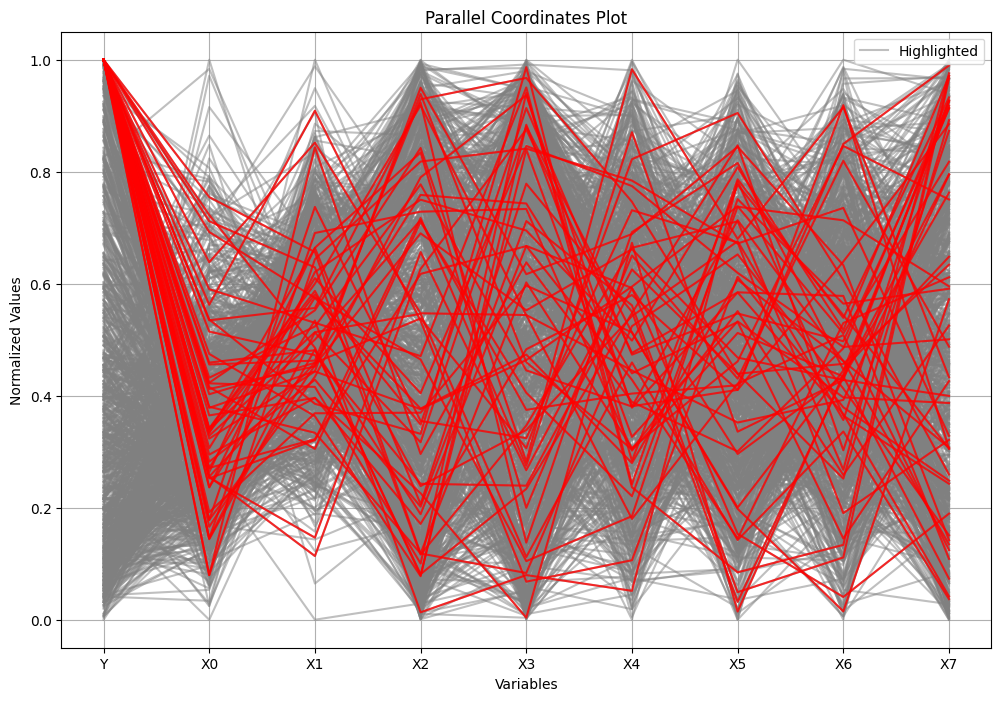

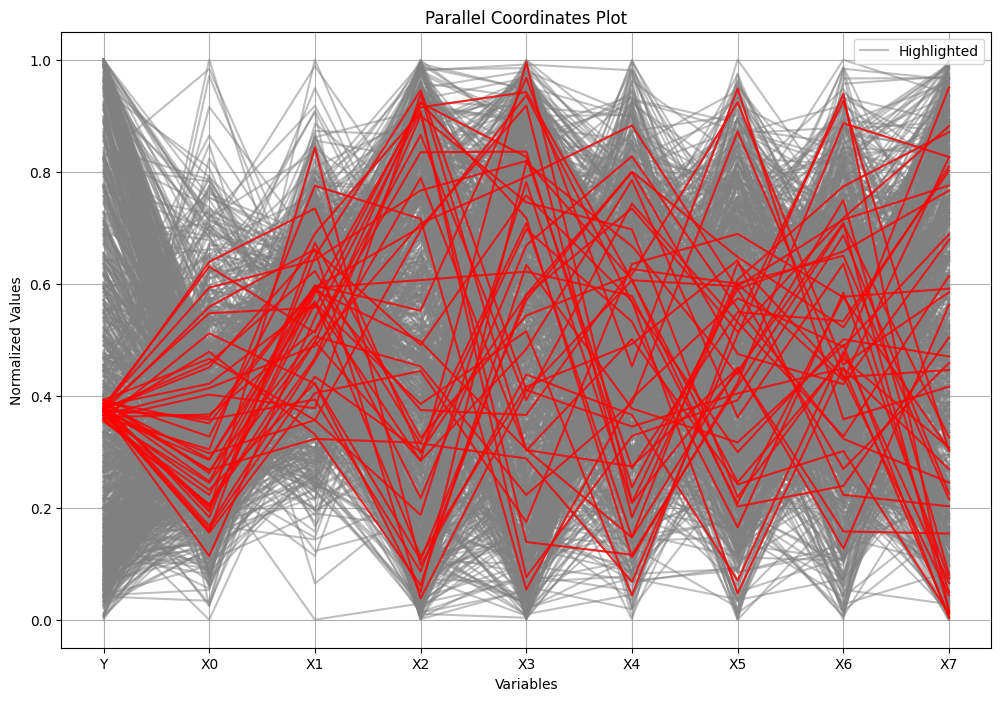

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def draw_parallel_coordinates(data, min_value, max_value, color='red', quantile_scale=True):
    """
    Draw a parallel coordinates plot.

    Parameters:
    - data: pandas DataFrame containing input and output samples.
    - min_value: Minimum value of the Y range.
    - max_value: Maximum value of the Y range.
    - color: Color for the highlighted lines.
    - quantile_scale: If True, use quantile scale for Y axis.
    """
    # Normalize the data to a 0-1 range
    def normalize(series):
        return (series - series.min()) / (series.max() - series.min())

    normalized_data = data.apply(normalize)

    # Determine the lines to highlight
    if quantile_scale:
        y_quantiles = normalized_data['Y'].quantile([min_value, max_value])
        highlight_lines = normalized_data[(normalized_data['Y'] >= y_quantiles[min_value]) &
                                          (normalized_data['Y'] <= y_quantiles[max_value])]
    else:
        highlight_lines = normalized_data[(normalized_data['Y'] >= min_value) &
                                          (normalized_data['Y'] <= max_value)]

    # Plot all lines
    plt.figure(figsize=(12, 8))
    for i, row in normalized_data.iterrows():
        plt.plot(normalized_data.columns, row, color='gray', alpha=0.5)
    
    # Plot highlighted lines
    for i, row in highlight_lines.iterrows():
        plt.plot(normalized_data.columns, row, color=color, alpha=0.8)

    plt.xlabel('Variables')
    plt.ylabel('Normalized Values')
    plt.title('Parallel Coordinates Plot')
    plt.grid(True)
    plt.legend(['Highlighted'], loc='upper right')
    plt.show()

# Load the combined data from CSV
combined_data = pd.read_csv("results/flood_model_plot_data.csv")

# Plot the parallel coordinates
# draw_parallel_coordinates(combined_data, 0.85, 1.0, color='red', quantile_scale=False)
# draw_parallel_coordinates(combined_data, 0.80, 1.0, color='red', quantile_scale=False)
draw_parallel_coordinates(combined_data, 0.95, 1.0, color='red', quantile_scale=True)
draw_parallel_coordinates(combined_data, 0.48, 0.52, color='red', quantile_scale=True)
